In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import datetime as dt
import statsmodels.api as sm
from scipy import stats

In [3]:
os_path = os.getcwd()
energy_df = pd.read_pickle(os.path.dirname(os_path)+'\\data\\energycons.pkl')

In [4]:
energy_df = energy_df['Load']

In [5]:
#aggregate to daily 
energy_df = energy_df.groupby(energy_df.index.strftime('%Y-%m-%d')).mean()
energy_df.index = pd.to_datetime(energy_df.index)

#limit the data only up to the end of 2020
energy_df = energy_df.loc[energy_df.index<'2021-01-01']
energy_df.head()

2015-01-01    4994.333333
2015-01-02    5249.416667
2015-01-03    5057.916667
2015-01-04    5230.083333
2015-01-05    5596.916667
Name: Load, dtype: float64

# Descriptive statistics for TS

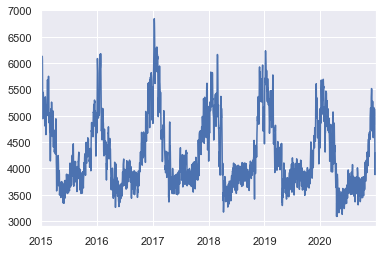

In [6]:
energy_df.plot();

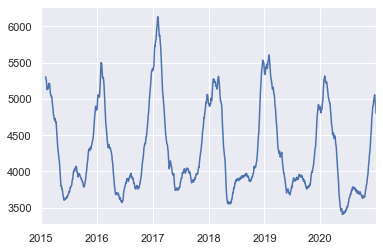

In [7]:
energy_df.rolling(30).mean().plot();

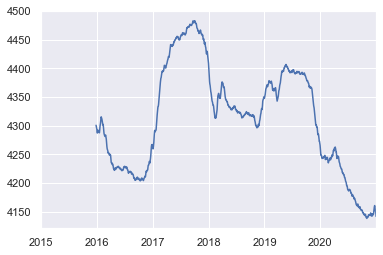

In [8]:
energy_df.rolling(360).mean().plot();

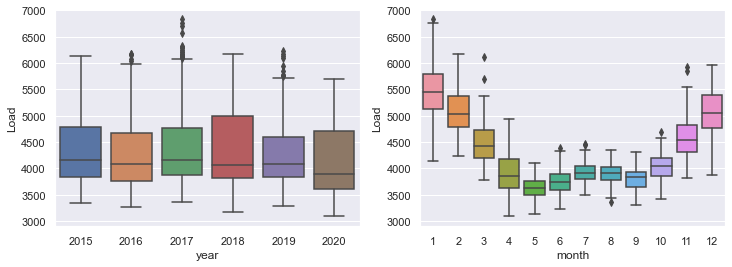

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))

sns_graph = pd.DataFrame(energy_df).copy()
sns_graph['year'] = sns_graph.index.year
sns_graph['month'] = sns_graph.index.month

sns.boxplot(x="year", y="Load", data=sns_graph, ax = axes[0]);
sns.boxplot(x="month", y="Load", data=sns_graph, ax = axes[1]);

# Distributional properties
TS data is often skewed to the right, especially when the series is a measure of something that can only be positive.

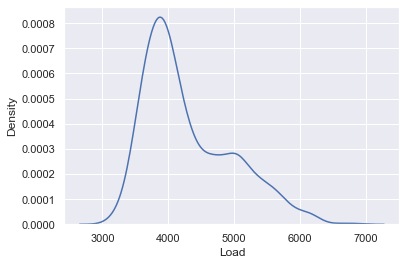

In [10]:
sns.kdeplot(energy_df);

## Possible transformations 

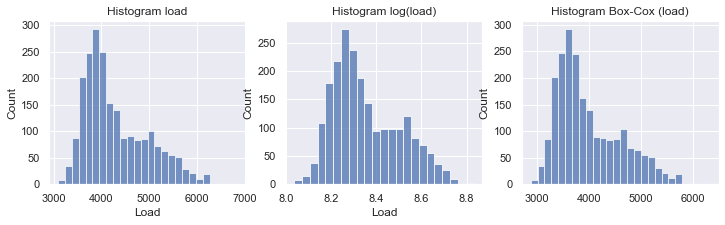

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(12,3))

sns.histplot(energy_df, ax = axes[0]);
axes[0].set_title('Histogram load')

sns.histplot(np.log(energy_df), ax = axes[1]);
axes[1].set_title('Histogram log(load)');

sns.histplot(stats.boxcox(energy_df, lmbda = 0.99), ax = axes[2]);
axes[2].set_title('Histogram Box-Cox (load)');

# Time Series Stationarity

 - Weak vs Strict Stationarity 
 - Weak stationarity implies:
  - 1st moment is constant over time
  - autocovariance is constant over time
  - 2nd moment is finite
 - Strict stationarity implies:
  - the unconditional joint probability distribution does not change over time
  
  Strict stationarity does not imply weak stationarity and vice versa.
  

## Trend vs Difference Stationarity
 - if a process needs to be differentiated d-times to arrive at stationarity, it is called integrated of order d, $X \sim I(d)$
 - if we need to eliminate a trend (by regressing the time series against a time polynomial of degree s), the series is trend-stationary
## Stationarity Tests

 - ADF test: $H_0$ = there is a unit root vs $H_\alpha$ = there isn't; different types of ADF:
  - no constant (drift) or trend in the OLS regression
  - constant (drift) in the OLS regression
  - constant (drift) and linear/quadratic trend
  - http://faculty.smu.edu/tfomby/eco6375/BJ%20Notes/ADF%20Notes.pdf
 - KPSS test:$H_0$ = the series is trend-stationary vs $H_\alpha$ = the series has a unit root

In [12]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

def test_stationarity(series, crit='BIC'):
    print_tests = 'Stationarity tests \n \
    P-values for: ADF with drift: {0:0.3f}, ADF drift and trend: {1:0.3f}, ADF no drift or trend: {2:0.3f} \n \
    KPSS p-value: {3:0.3f}'
    adftest_c = adfuller(series, autolag='BIC', regression = 'c')
    adftest_ct = adfuller(series, autolag='BIC', regression = 'ct')
    adftest_nc = adfuller(series, autolag='BIC', regression = 'nc')
    kpsstest = kpss(series)

    return print(print_tests.format(adftest_c[1], adftest_ct[1], adftest_nc[1], kpsstest[1]))
    
test_stationarity(energy_df, 'BIC')

Stationarity tests 
     P-values for: ADF with drift: 0.000, ADF drift and trend: 0.014, ADF no drift or trend: 0.383 
     KPSS p-value: 0.100


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


# Autocorrelation and partial autocorrelation functions (ACF and PACF)


### Rule of thumb for 'guessing' lag orders of an ARMA process
|  | ACF | PACF |
| --- | --- | --- |
| AR(p) process| decays exponentially (monotonically or oscillating to zero) | p lags |
| MA(q) process | q lags | decays exponentially (monotonically or oscillating to zero) |

In [13]:
def plot_acf_pacf(series, nlags):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    sm.graphics.tsa.plot_acf(series, lags=nlags, ax = axes[0])
    axes[0].set_title('Sample ACF')

    sm.graphics.tsa.plot_pacf(series, lags=nlags, ax = axes[1])
    axes[1].set_title('Sample PACF')
    
    return fig

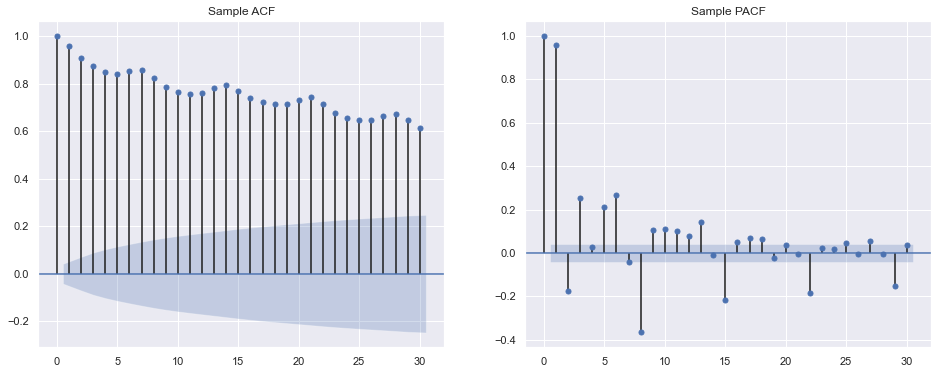

In [49]:
plot_acf_pacf(energy_df, 30);

# Seasonality in TS data

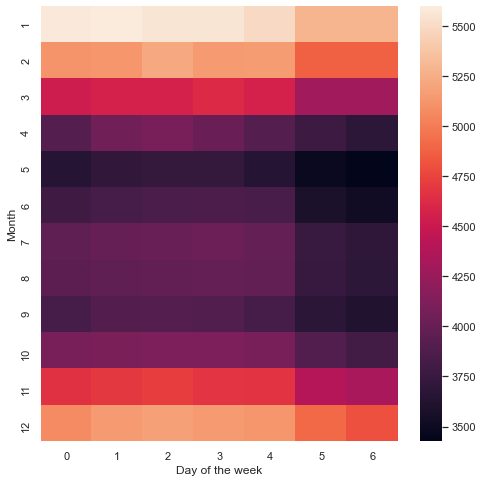

In [15]:
dfnew = pd.DataFrame(energy_df.copy())
dfnew['Month'] = energy_df.index.month
dfnew['Day of the week'] = energy_df.index.weekday

dfnew = pd.pivot_table(dfnew, values='Load', index=['Month'],
                     columns=['Day of the week'], aggfunc=np.mean, fill_value=0)

fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(dfnew);

# Seasonal Decomposition

## Seasonal Decomposition using moving average
statsmodels: https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html
- Additive 
- Multiplicative


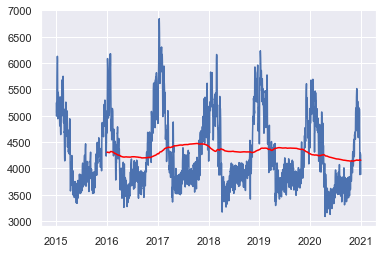

In [16]:
energy_df_ma = energy_df.rolling(365).mean()
#energy_df_ma_std = energy_df.rolling(365).std()

plt.plot(energy_df)
plt.plot(energy_df_ma, color='red');

### Naive seasonal decomposition based on moving average of the series
We estimate the centered moving average for the seasonality preiod (4 for quarterly data, 12 for monthly and others).

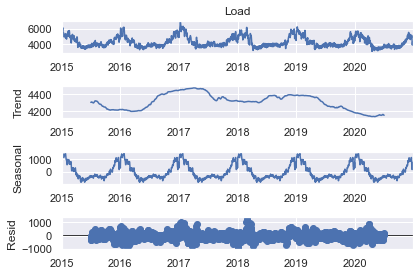

In [17]:
energy_df = energy_df.asfreq('d')
from statsmodels.tsa.seasonal import seasonal_decompose
results_additive = seasonal_decompose(energy_df, model='additive', period = 365)
results_additive.plot();

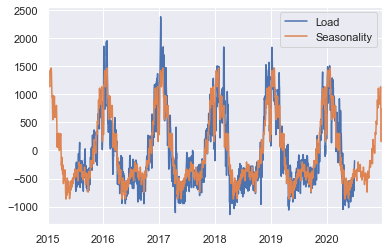

In [18]:
graph = pd.DataFrame(energy_df - energy_df.rolling(365, center=True).mean())
graph['Seasonality'] = results_additive.seasonal
graph.plot();

## Multiple seasonalities
Some series have more complex seasonality patterns. The daily electricity load, for example, has both annual and weekly seasonality. After extracting the annual seasonal component from the initial series, we can re-apply the the naive seasonality decomposition procedures to the residuals we have derived.

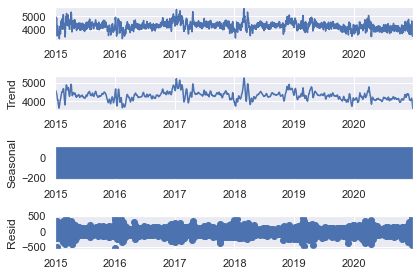

In [19]:
decomp_annual_df = energy_df - results_additive.seasonal
results_additive_weekly = seasonal_decompose(decomp_annual_df, model='additive', period = 7)
results_additive_weekly.plot();

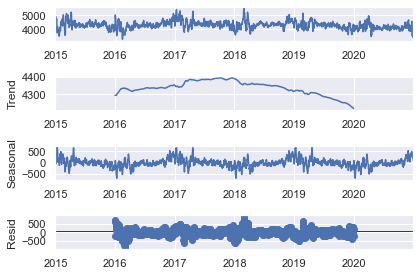

In [20]:
decomp_df = decomp_annual_df - results_additive_weekly.seasonal
results_additive_ann2 = seasonal_decompose(decomp_df, model='additive', period = 365*2)
results_additive_ann2.plot();

In [21]:
decomp_df = decomp_df - results_additive_ann2.seasonal

### OLS regression
We can also run an OLS regression with dummies for the days of the week on the residuals, and we can see the effect each weekday has on the total load.

In [23]:
weekday_df = pd.DataFrame(decomp_annual_df, index = pd.to_datetime(decomp_annual_df.index), columns=['y'])
weekday_df['dayoftheweek'] = weekday_df.index.weekday
X = pd.get_dummies(weekday_df['dayoftheweek'], prefix='day', drop_first=True)

X = sm.add_constant(X)
model = sm.OLS(weekday_df['y'], X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     70.36
Date:                Thu, 04 Feb 2021   Prob (F-statistic):           2.43e-80
Time:                        14:06:07   Log-Likelihood:                -15375.
No. Observations:                2192   AIC:                         3.076e+04
Df Residuals:                    2185   BIC:                         3.080e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4339.9546     15.238    284.808      0.0

## STL decomposition

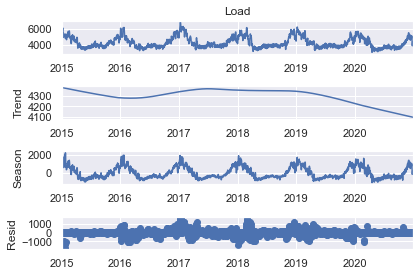

In [24]:
from statsmodels.tsa.seasonal import STL
stl = STL(energy_df, period=365, robust=True)
res_STL = stl.fit()
fig = res_STL.plot()

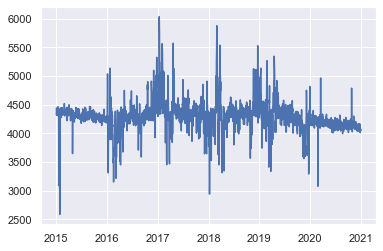

In [25]:
newdf = energy_df - res_STL.seasonal
plt.plot(newdf);

### Spectral analysis
Every time series can be analyzed in the time or frequency domain. The intuition behind this is that it can be represented as a ..

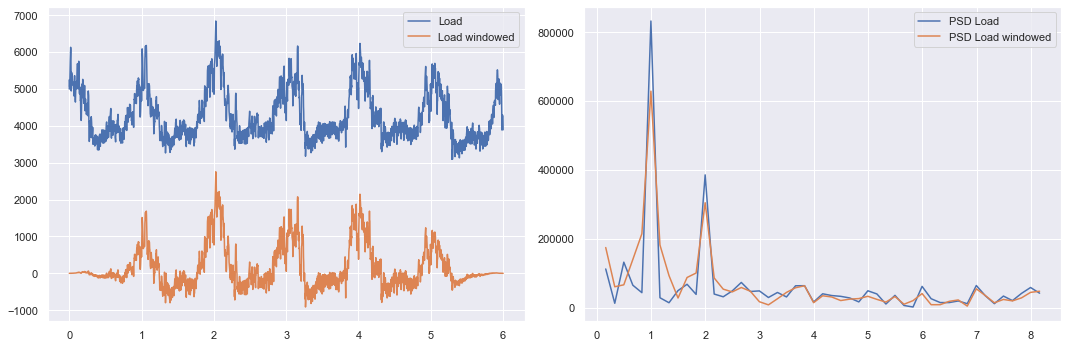

In [27]:
from numpy.fft import rfft, rfftfreq
from scipy.signal import tukey
from numpy.fft import fft, fftshift

#a_gtrend_orig = energy_df
t_energy_df = np.linspace( 0, len(energy_df)/365, len(energy_df), endpoint=False )
#note the choice of window matters
energy_df_window = (energy_df-np.median(energy_df))*tukey(len(energy_df))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
#plt.subplot( 2, 1, 1 )
ax[0].plot(t_energy_df, energy_df, label='Load')
ax[0].plot(t_energy_df, energy_df_window, label='Load windowed' )
ax[0].legend()

energy_df_fft = abs(rfft(energy_df))
energy_df_tukey = abs(rfft(energy_df_window) )

#set d to the inverse of the step (365 days in 1 year)
energy_df_freqs = rfftfreq( len(energy_df), d = 1/365 )


ax[1].plot(energy_df_freqs[1:50], energy_df_fft[1:50], label='PSD Load' )
ax[1].plot(energy_df_freqs[1:50], energy_df_tukey[1:50], label='PSD Load windowed' )
ax[1].legend()

plt.tight_layout()
plt.show()

### stationarity testing, SACF and SPACF post seasonal decomposition

C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Stationarity tests 
     P-values for: ADF with drift: 0.000, ADF drift and trend: 0.000, ADF no drift or trend: 0.433 
     KPSS p-value: 0.010


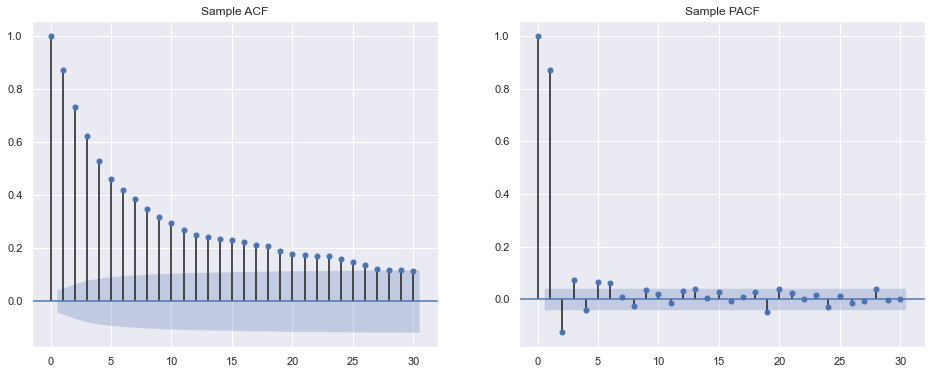

In [28]:
#decomp_df = decomp_annual_df - results_additive_weekly.seasonal
test_stationarity(decomp_df)
plot_acf_pacf(decomp_df, nlags = 30);

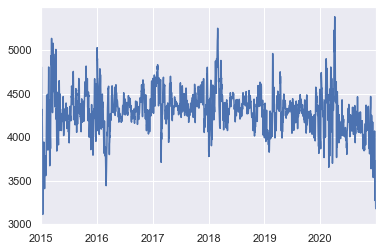

In [29]:
decomp_df.plot();

# ARIMA (p, d, q) models 

## Wald's Decomposition
Every weakly stationary, purely nondeterministic, stochastic process $x-\mu$ can be expressed as a linear combination of a sequence of random variables:
$x-\mu = a_t+\psi_1a_{t-1} + ... = \sum_{j = 0}^{\infty}\psi_j a_{t-j}$, where $a_t \sim WN(0, \sigma^2)$


- AR(p) models can be estimated by OLS (efficient estimator)
- ARMA(p, q) models are estimated using MLE, as the MA(q) process is not directly observed in the data
- ARMA can be used only on stationary, invertible and causal stochastic processes
- if the series is I(d), or integrated of order d, we can use the ARIMA(p, d, q) model

## Steps when modeling an ARMA/ARIMA process

#### Step 1: Transform the series to achieve stationarity
 - transform the series into log-s, difference or remove trend if necessary
 - remove seasonality
 
#### Step 2: Find the p and q order
 - investigate the sample ACF and PACF
 
#### Step 3: Diagnostics checking
 - observing the residuals from the fitted model for misspecifications such as
 - autocorrelated residuals (SACF), Ljung-Box test
 - overfit the model by including p+1/q+1 lags in order to check if they are significant
 - invesetigate out-of-sample performance of the mode, does it deliver sensible forecasts?

## Choosing lags (hyperpar-s) based on information criteria
- AIC: $AIC(p, q) = log\hat{\sigma}^2 + 2(p+q)T^{-1}$
- BIC: $BIC(p, q) = log\hat{\sigma}^2 + (p+q)T^{-1}logT$
- BIC is *strongly consistent*, or in other words chooses the 'true' model asymptotically, whereas AIC will choose an over-parametrized model (might be better for forecasting)

In [31]:
from statsmodels.tsa.ar_model import AutoReg
res = sm.tsa.arima.ARIMA(decomp_df, order=(7, 0, 0), enforce_stationarity=False).fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2192
Model:                 ARIMA(7, 0, 0)   Log Likelihood              -13419.608
Date:                Thu, 04 Feb 2021   AIC                          26857.217
Time:                        14:07:57   BIC                          26908.421
Sample:                    01-01-2015   HQIC                         26875.934
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4300.2226     22.159    194.058      0.000    4256.791    4343.654
ar.L1          1.0165      0.014     71.763      0.000       0.989       1.044
ar.L2         -0.2325      0.021    -11.256      0.0

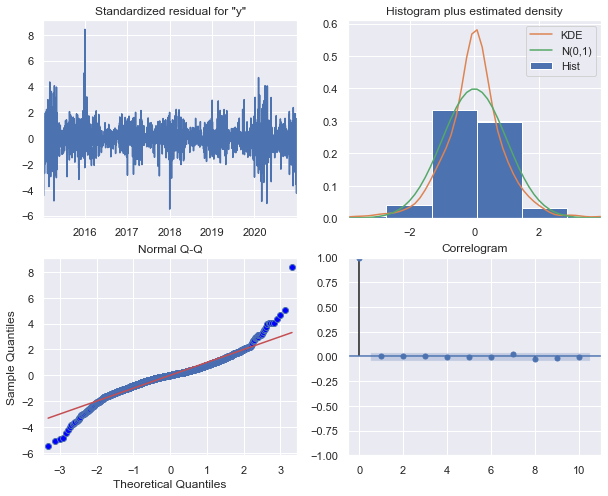

In [32]:
res.plot_diagnostics(figsize = (10, 8));

## ARCH/GARCH processes

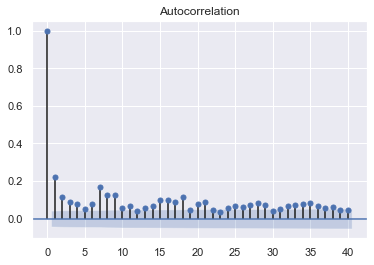

In [33]:
residuals = res.resid

sm.graphics.tsa.plot_acf(residuals**2, lags=40)
plt.show()

# Automized ways of tuning the ARIMA/SARIMA hyperpar-s

In [34]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split

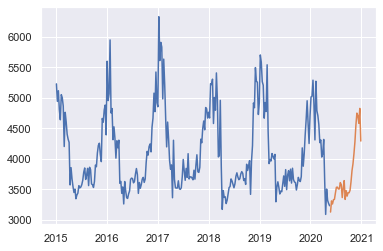

In [35]:
energy_weekly = energy_df.asfreq('w')
train, test = train_test_split(energy_weekly, train_size=int(0.9*len(energy_weekly)))
plt.plot(train)
plt.plot(test);

In [125]:
model = pm.auto_arima(train, start_p = 0, start_q = 0, 
                      max_p = 5, max_d = 2, max_q = 5, information_criterion='aic',
                      test = 'adf', max_P=2, max_D=1, max_Q=2, max_order=2, m=52, trace=True,
                      maxiter = 50, stepwise = True, seasonal=True)


Performing stepwise search to minimize aic
Fit ARIMA(0,0,0)x(1,0,1,52) [intercept=True]; AIC=4319.704, BIC=4334.257, Time=20.238 seconds
Fit ARIMA(0,0,0)x(0,0,0,52) [intercept=True]; AIC=4437.751, BIC=4445.028, Time=0.026 seconds
Fit ARIMA(1,0,0)x(1,0,0,52) [intercept=True]; AIC=4069.614, BIC=4084.168, Time=13.379 seconds


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Fit ARIMA(0,0,1)x(0,0,1,52) [intercept=True]; AIC=4197.216, BIC=4211.770, Time=12.183 seconds
Fit ARIMA(0,0,0)x(0,0,0,52) [intercept=False]; AIC=5484.192, BIC=5487.830, Time=0.024 seconds
Fit ARIMA(1,0,0)x(0,0,0,52) [intercept=True]; AIC=4074.219, BIC=4085.134, Time=0.083 seconds


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Fit ARIMA(1,0,0)x(2,0,0,52) [intercept=True]; AIC=4061.045, BIC=4079.237, Time=296.096 seconds
Near non-invertible roots for order (1, 0, 0)(2, 0, 0, 52); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.991)


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Fit ARIMA(1,0,0)x(1,0,1,52) [intercept=True]; AIC=4069.365, BIC=4087.556, Time=29.878 seconds


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Fit ARIMA(1,0,0)x(0,0,1,52) [intercept=True]; AIC=4071.819, BIC=4086.372, Time=4.464 seconds


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Fit ARIMA(1,0,0)x(2,0,1,52) [intercept=True]; AIC=4063.900, BIC=4085.730, Time=356.105 seconds


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Fit ARIMA(1,0,0)x(2,0,2,52) [intercept=True]; AIC=4064.817, BIC=4090.286, Time=631.962 seconds
Near non-invertible roots for order (1, 0, 0)(2, 0, 2, 52); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.997)


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Fit ARIMA(1,0,0)x(1,0,2,52) [intercept=True]; AIC=4062.767, BIC=4084.597, Time=230.572 seconds


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Fit ARIMA(1,0,0)x(0,0,2,52) [intercept=True]; AIC=4067.265, BIC=4085.457, Time=211.894 seconds


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Fit ARIMA(0,0,0)x(1,0,2,52) [intercept=True]; AIC=4237.249, BIC=4255.441, Time=275.002 seconds
Near non-invertible roots for order (0, 0, 0)(1, 0, 2, 52); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Fit ARIMA(2,0,0)x(1,0,2,52) [intercept=True]; AIC=4038.959, BIC=4064.428, Time=414.315 seconds


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Fit ARIMA(2,0,0)x(0,0,2,52) [intercept=True]; AIC=4042.773, BIC=4064.603, Time=325.665 seconds


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Fit ARIMA(2,0,0)x(1,0,1,52) [intercept=True]; AIC=4044.324, BIC=4066.154, Time=121.134 seconds


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Fit ARIMA(2,0,0)x(2,0,2,52) [intercept=True]; AIC=4041.832, BIC=4070.939, Time=373.794 seconds
Near non-invertible roots for order (2, 0, 0)(2, 0, 2, 52); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.997)


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Fit ARIMA(2,0,0)x(0,0,1,52) [intercept=True]; AIC=4048.783, BIC=4066.974, Time=6.721 seconds


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Fit ARIMA(2,0,0)x(2,0,1,52) [intercept=True]; AIC=4040.183, BIC=4065.652, Time=775.851 seconds


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Fit ARIMA(3,0,0)x(1,0,2,52) [intercept=True]; AIC=4027.043, BIC=4056.150, Time=620.493 seconds


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Fit ARIMA(3,0,0)x(0,0,2,52) [intercept=True]; AIC=4031.627, BIC=4057.096, Time=188.744 seconds


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Fit ARIMA(3,0,0)x(1,0,1,52) [intercept=True]; AIC=4033.920, BIC=4059.388, Time=43.753 seconds


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Fit ARIMA(3,0,0)x(2,0,2,52) [intercept=True]; AIC=4031.203, BIC=4063.948, Time=896.201 seconds
Near non-invertible roots for order (3, 0, 0)(2, 0, 2, 52); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Fit ARIMA(3,0,0)x(0,0,1,52) [intercept=True]; AIC=4041.558, BIC=4063.388, Time=48.319 seconds


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\pmdarima\arima\_auto_solvers.py:399: ModelFitWarning: Error fitting ARIMA(3,0,0)x(2,0,1,52) [intercept=True] (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\pmdarima\arima\_auto_solvers.py", line 377, in _fit_arima
    fit = ARIMA(order=order, seasonal_order=seasonal_order,
  File "C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\pmdarima\arima\arima.py", line 470, in fit
    self._fit(y, exogenous, **fit_args)
  File "C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\pmdarima\arima\arima.py", line 395, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\pmdarima\arima\arima.py", line 383, in _fit_wrapper
    return arima, arima.fit(start_params=start_p

Fit ARIMA(3,0,0)x(2,0,1,52) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(4,0,0)x(1,0,2,52) [intercept=True]; AIC=4029.402, BIC=4062.147, Time=329.981 seconds


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Fit ARIMA(3,0,1)x(1,0,2,52) [intercept=True]; AIC=4028.429, BIC=4061.174, Time=211.025 seconds


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Fit ARIMA(2,0,1)x(1,0,2,52) [intercept=True]; AIC=4035.685, BIC=4064.792, Time=139.147 seconds


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Fit ARIMA(4,0,1)x(1,0,2,52) [intercept=True]; AIC=4031.486, BIC=4067.870, Time=190.963 seconds
Total fit time: 8786.641 seconds


In [82]:
print(model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 1534
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 7)   Log Likelihood               -9785.710
Date:                             Tue, 02 Feb 2021   AIC                          19587.420
Time:                                     17:10:02   BIC                          19630.105
Sample:                                          0   HQIC                         19603.304
                                            - 1534                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    686.3731    110.610      6.205      0.000     469.582     903.164
ar.L1         -0.3320      

In [141]:
forecast_mean_ci = model.predict(n_periods = len(test), return_conf_int=True) 
forecast = pd.DataFrame(forecast_mean_ci[0], index = test.index)
forecast.columns = ['Forecast']
forecast[['upper_ci','lower_ci']] = forecast_mean_ci[1]

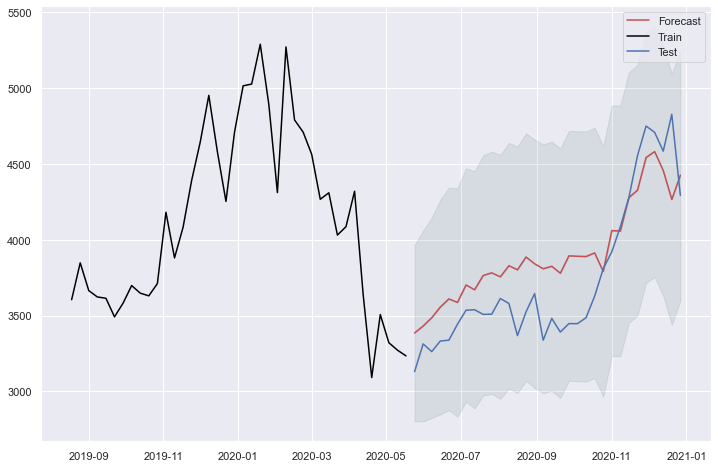

In [142]:
#graph
plt.figure(figsize=(12, 8))
plt.plot(forecast['Forecast'], color='r');
plt.plot(train.iloc[-40:], color='black')
plt.plot(test, color='b')
plt.fill_between(forecast.index, forecast['upper_ci'], forecast['Forecast'], alpha = 0.1, color='darkslategrey')
plt.fill_between(forecast.index, forecast['lower_ci'], forecast['Forecast'], alpha = 0.1, color='darkslategrey')
plt.legend(['Forecast', 'Train', 'Test']);

# Unobserved Components Model
Structural time series models that decompose a series into trend, seasonal, cyclical, and irregular components.

                                 Unobserved Components Results                                 
Dep. Variable:                                       y   No. Observations:                 2192
Model:                                 fixed intercept   Log Likelihood              -14686.588
                      + stochastic freq_seasonal(7(1))   AIC                          29377.176
                   + stochastic freq_seasonal(365(16))   BIC                          29388.529
Date:                                 Thu, 04 Feb 2021   HQIC                         29381.329
Time:                                         14:08:39                                         
Sample:                                              0                                         
                                                - 2192                                         
Covariance Type:                                   opg                                         
                                   coef 

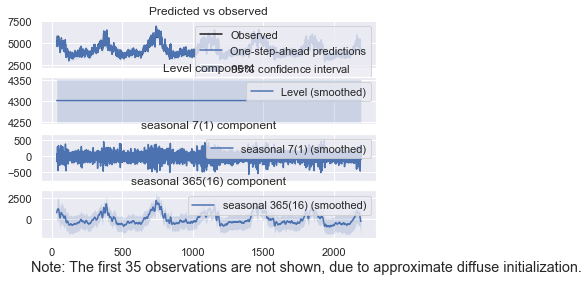

In [36]:
model = sm.tsa.UnobservedComponents(energy_df.values,
                                    level = 'fixed intercept',
                                    freq_seasonal=[{'period': 7,
                                                    'harmonics': 1},
                                                    {'period': 365,
                                                     'harmonics': 16}])
res_f = model.fit(disp=False)
# The first state variable holds our estimate of the intercept
print(res_f.summary())
print("fixed intercept estimated as {0:.3f}".format(res_f.smoother_results.smoothed_state[0,-1:][0]))

res_f.plot_components()
plt.show()

In [37]:
from datetime import datetime
def plot_forecast(series, resultsclass, start_date, end_date, dynamic):
    #get datetime fron the string dates
    start_date_dt = datetime.strptime(start_date, '%Y-%m-%d')
    end_date_dt = datetime.strptime(end_date, '%Y-%m-%d')
    #new index for the foreacast df
    new_index = pd.date_range(start_date_dt, end_date_dt)
    #calculate int indices
    index_start_date = series.index.get_loc(start_date)
    index_end_date = index_start_date + len(new_index)-1
    #get the forecast
    df = resultsclass.get_prediction(index_start_date, index_end_date, dynamic).summary_frame()
    df.index = new_index
    #graph
    plt.figure(figsize=(12, 8))
    plt.plot(df['mean'], color='r');
    plt.plot(series.loc[series.index>start_date], color='black')
    plt.fill_between(df.index, df['mean_ci_lower'], df['mean'], alpha = 0.1, color='darkslategrey')
    plt.fill_between(df.index, df['mean_ci_upper'], df['mean'], alpha = 0.1, color='darkslategrey')
    
    return()


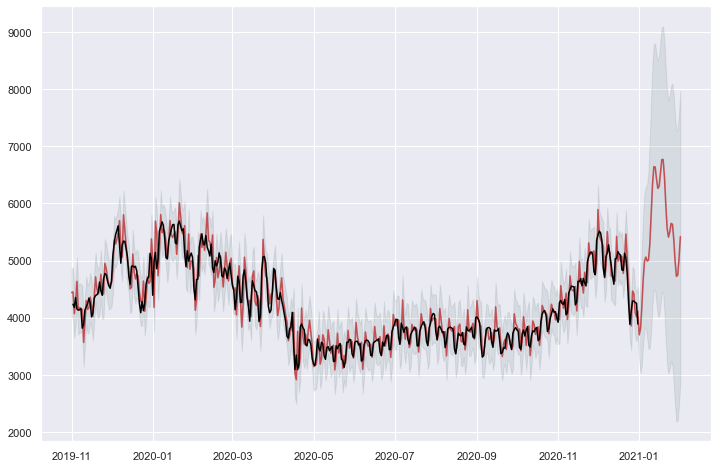

In [38]:
plot_forecast(energy_df, res_f, '2019-11-01', '2021-02-01', False);

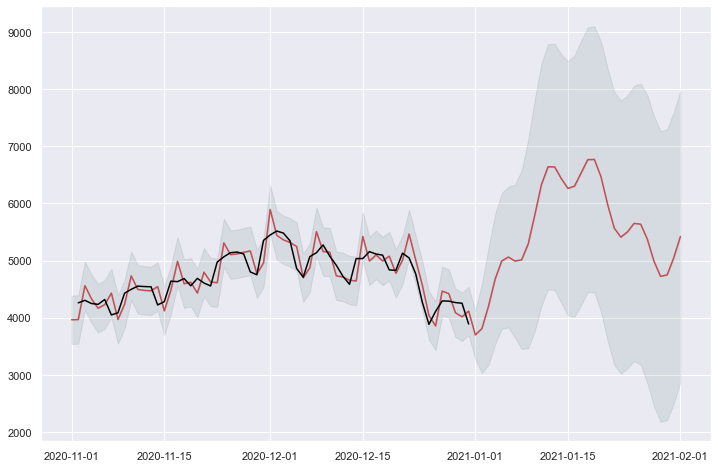

In [39]:
plot_forecast(energy_df, res_f, '2020-11-01', '2021-02-01', False);

# Theta model

In [41]:
from statsmodels.tsa.forecasting.theta import ThetaModel
tm = ThetaModel(energy_df)
res = tm.fit()
print(res.summary())

                              ThetaModel Results                              
Dep. Variable:                   Load   No. Observations:                 2192
Method:                       OLS/SES   Deseasonalized:                   True
Date:                Thu, 04 Feb 2021   Deseas. Method:         Multiplicative
Time:                        14:09:00   Period:                              7
Sample:                    01-01-2015                                         
                         - 12-31-2020                                         
   Parameter Estimates    
           Parameters     
--------------------------
b0    -0.09973647707028749
alpha   0.9998483362657071
--------------------------


# Exponential Smoothing
Exponential smoothing applies different dampening weights to past observations of the series; the intuition behind it is that the further away in the past an observation happened, the less it should matter for the forecast. 

$\hat{y}_{T+1|T} = \alpha y_T + \alpha(1-\alpha) y_{T-1} + \alpha(1-\alpha)^2 y_{T-2} + ...$, where $0\leq \alpha \leq 1$ is the smoothing parameter.
### Simple exponential smoothing
 - for data with no clear trend or seasonality

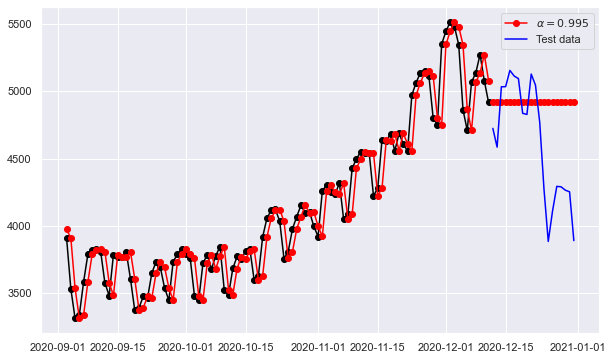

In [47]:
train, test = train_test_split(energy_df, train_size=len(energy_df)-20)
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt

fit_ses = SimpleExpSmoothing(train, initialization_method="estimated").fit()
fcast_ses = fit_ses.forecast(20).rename(r'$\alpha=%s$'%fit_ses.model.params['smoothing_level'])

plt.figure(figsize=(10, 6))
plt.plot(train.iloc[-100:], marker='o', color='black')
plt.plot(fit_ses.fittedvalues.iloc[-100:], marker='o', color='red')
line1, = plt.plot(fcast_ses, marker='o', color='red')
line2, = plt.plot(test,  color='blue')

plt.legend([line1, line2,], [fcast_ses.name, 'Test data']);

### Holt's Method

C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


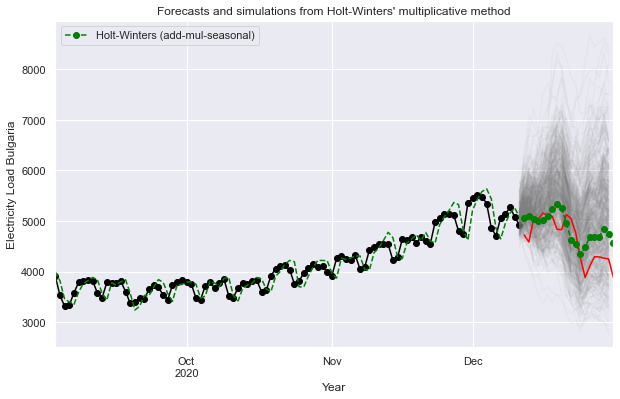

In [48]:
fit = ExponentialSmoothing(train, seasonal_periods=365, trend='mul', seasonal='mul', initialization_method="estimated").fit()
simulations = fit.simulate(20, anchor='2020-12-11', repetitions=500, error='mul', random_errors='bootstrap')

ax = train.iloc[-100:].plot(figsize=(10,6), marker='o', color='black',
               title="Forecasts and simulations from Holt-Winters' multiplicative method" )
ax.set_ylabel("Electricity Load Bulgaria")
ax.set_xlabel("Year")
fit.fittedvalues.iloc[-100:].plot(ax=ax, style='--', color='green')
simulations.plot(ax=ax, style='-', alpha=0.05, color='grey', legend=False)
test.rename('Test data').plot(ax=ax, style='-',  color='red')
fit.forecast(20).rename('Holt-Winters (add-mul-seasonal)').plot(ax=ax, style='--', marker='o', color='green', legend=True)
plt.show()

# TBATS and BATS
good for complex seasonality

In [111]:
from tbats import TBATS, BATS

In [120]:
train, test = train_test_split(energy_df, train_size=len(energy_df)-100)

# Fit the model
estimator = TBATS(seasonal_periods=(7, 365.25))
model_tbats = estimator.fit(train)

print(model_tbats.summary())

Use Box-Cox: True
Use trend: True
Use damped trend: True
Seasonal periods: [  7.   365.25]
Seasonal harmonics [ 3 11]
ARMA errors (p, q): (0, 0)
Box-Cox Lambda 0.000000
Smoothing (Alpha): 1.203012
Trend (Beta): -0.277263
Damping Parameter (Phi): 0.800000
Seasonal Parameters (Gamma): [ 7.10256221e-09  1.42718421e-07 -6.85976046e-08  2.87565010e-07]
AR coefficients []
MA coefficients []
Seed vector [ 8.45479382e+00  1.15129300e-03  2.57329689e-02  9.06978557e-04
 -3.37099101e-03 -2.69178972e-02  1.75832362e-02 -5.15615067e-03
  1.69567367e-01  6.12795621e-02 -8.55357855e-03  6.24152916e-04
 -4.12236174e-03 -9.98909753e-03 -1.08333351e-02 -6.36218391e-03
 -1.92581816e-03 -4.95015474e-03 -1.04971808e-02  5.56083017e-03
  4.11880999e-02 -1.37942979e-02 -5.35849067e-04  4.61626532e-03
  1.09794632e-03  2.31040336e-03  6.12661223e-03  1.52866579e-02
  8.38032551e-03  9.26863396e-03]

AIC 36409.912343


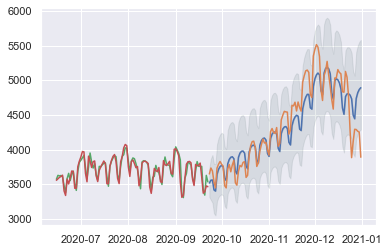

In [121]:
forecast_tbats = pd.DataFrame(model_tbats.forecast(steps=len(test), confidence_level=0.95)[1], index = test.index)
plt.plot(forecast_tbats['mean'], label='TBATS')
plt.plot(test, label = 'Test');
plt.plot((pd.DataFrame(model_tbats.y_hat, index = train.index).iloc[-100:]))
plt.plot((train.iloc[-100:]))
plt.fill_between(test.index, forecast_tbats['lower_bound'], forecast_tbats['mean'], alpha = 0.1, color='darkslategrey')
plt.fill_between(test.index, forecast_tbats['upper_bound'], forecast_tbats['mean'], alpha = 0.1, color='darkslategrey');

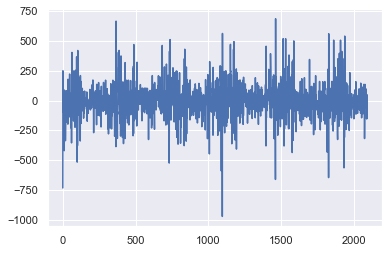

In [122]:
plt.plot(model_tbats.resid);